## Part 1 : Training

In the following notebook, we experimented with different CNN architectures to improve the model's accuracy. We trained and evaluated the following two models: 

1-CNN with three layers for feature extraction 

2-Using the transfer learning approach with a pre-trained VGG model

We selected the model with the highest accuracy on the validation dataset for further evaluation.

### Get libraries

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import torch 
from torchvision import datasets, io
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os 
import matplotlib.pyplot as plt 
import numpy as np
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules import transformer

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Now we load the data into tensors

$Note$: I loaded and extracted the data on my PC (which was much faster), and saved it as tensors (pt files). The following script is what I used to extract the data.

In [ ]:
path_to_folder="/content/gdrive/MyDrive/space/2750"
targets=os.listdir("/content/gdrive/MyDrive/space/2750")

## Split the data into train, val and test set

In [ ]:
# make sure that the total ratio is equal to 1
TRAIN_RATIO=0.8
TEST_RATIO=0.1
VAL_RATIO=0.1

assert TRAIN_RATIO+TEST_RATIO+VAL_RATIO==1, "check if the sum of the ration is equal to 1"

# split the data into train, test, val sets
train_data_set=[]
test_data_set=[]
val_data_set=[]

train_labels_set=[]
test_labels_set=[]
val_labels_set=[]

# we make sure that every data set contain all the labels, specialy in the train data set, so our model can see all diffrent corrrespending image to label

for i in targets:
    path=path_to_folder+"/"+i
    label_size=len(os.listdir(path))

    for c, j in enumerate(os.listdir(path)):
        image=io.read_image(path+"/"+j)
        if c<=TRAIN_RATIO*label_size:
            train_data_set.append(image)
            train_labels_set.append(targets.index(i))
        elif c<(TRAIN_RATIO+TEST_RATIO)*label_size:
            test_data_set.append(image)
            test_labels_set.append(targets.index(i))
        else : 
            val_data_set.append(image)
            val_labels_set.append(targets.index(i))

train_data_set=torch.stack(train_data_set)
train_labels_set=torch.tensor(train_labels_set)
test_data_set=torch.stack(test_data_set)
test_labels_set=torch.tensor(test_labels_set)
val_data_set=torch.stack(val_data_set)
val_labels_set=torch.tensor(val_labels_set)

In [ ]:
train_data_set=torch.load("/content/gdrive/MyDrive/space/Sat_tensor/train_data.pt").to(device)/255.0
train_labels_set=torch.load("/content/gdrive/MyDrive/space/Sat_tensor/train_label.pt").to(device)
val_data_set=torch.load("/content/gdrive/MyDrive/space/Sat_tensor/val_data.pt").to(device)/255.0
val_labels_set=torch.load("/content/gdrive/MyDrive/space/Sat_tensor/val_label.pt").to(device)

### Put the dataset in a dataloader. Therefore, we need to create a custom dataset class.

In [ ]:
class ImageDataset(Dataset): 
    def __init__(self, images, labels, transformer=None) -> None:
        self.data=images
        self.labels=labels
        if transformer:
          self.transformer=transformer
        
    def __len__(self): 
        return len(self.labels)
        
    def __getitem__(self, idx):

        data=self.data[idx]
        label=self.labels[idx]

        if self.transformer:
          data=self.transformer(data)
        
        
        return self.data[idx], self.labels[idx]

possible data augmentation but i will use only the normalization

In [ ]:
data_augmentation=transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1)
])

norm=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
                
                ])

In [ ]:
BATCH_SIZE=32

SAT_train_v1=ImageDataset(train_data_set, train_labels_set, norm)
SAT_val_v1=ImageDataset(val_data_set, val_labels_set, norm)

SAT_train=DataLoader(SAT_train_v1, batch_size=BATCH_SIZE, shuffle=True)
SAT_val=DataLoader(SAT_val_v1, batch_size=BATCH_SIZE, shuffle=True)

## Let's make our first model

Some explanations on the model parameters : 
* padding equals 1 This ensures that the output feature maps have the same spatial size as the input data, which helps to preserve important spatial information through the layers of the network.
* Batchnorm to normalize the output of each layer therefor the weight, also it's well now for it fast convergence 
* Max pooling is particularly useful for preserving spatial invariance, which is important in satellite image processing, but its not a rule just a suggestion that could be usefull.

In [ ]:
class SAT_CNN(nn.Module): 
    def __init__(self) -> None:
        super().__init__()

        self.features=nn.Sequential(
            #1
            nn.Conv2d(3, 32, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=1, padding=0),
            #2
            nn.Conv2d(32, 64, (3,3), stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=1, padding=0),
            #3
            nn.Conv2d(64, 128, (3,3), stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=1, padding=0),
        ).to(device)

        self.classifier=nn.Sequential(
            nn.Linear(476288, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
        ).to(device)


    def forward(self, x):

        if len(x.shape)==3:
            x=torch.unsqueeze(x, 0) # pour le cas d'une seul image 

        features=self.features(x)
        flat=torch.flatten(features,1)
        results=self.classifier(flat)
        return results

In [ ]:
mdl=SAT_CNN()
learning_rate=1e-4 # with the amount of parameters we should lower the learning rate

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(mdl.parameters(), lr=learning_rate)
# we add a shedullar
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.1)

### Train our model

In [ ]:
EPOCHS=30

In [ ]:
def train(mdl, loss_fn, optimizer,epochs=100, lr_scheduler=None):
  loss_list=[]
  accuracy_val=[]
  accuracy_train=[]

  for i in range(epochs):
      loss_perepoch=[]
      accuracy_perepoch=[]
      accuracy_train_perepoch=[]

      for k, j in enumerate(SAT_train):
          data, labels=j
          optimizer.zero_grad()
          outputs=mdl(data)
          loss=loss_fn(outputs, labels)
          loss.backward()

          loss_perepoch.append(float(loss.detach()))
          optimizer.step()

          _, outputs=torch.max(outputs, 1)
          accuracy_train_perepoch.append(outputs.eq(labels))

      if lr_scheduler:
        lr_scheduler.step()

      accuracy_train_perepoch=torch.concat(accuracy_train_perepoch)
      accuracy_train.append((accuracy_train_perepoch.sum().item())/len(accuracy_train_perepoch))

      loss_list.append(sum(loss_perepoch)/len(loss_perepoch))
      
      for k,j in enumerate(SAT_val):
          data, labels=j

          with torch.no_grad():
              outputs=mdl(data)
              _, outputs=torch.max(outputs, 1)

              accuracy_perepoch.append(outputs.eq(labels))

      accuracy_perepoch=torch.concat(accuracy_perepoch)
      accuracy_val.append((accuracy_perepoch.sum().item())/len(accuracy_perepoch))
          

      print(f"epoch : {i}, loss: {sum(loss_perepoch)/len(loss_perepoch)}, accuracy: {(accuracy_perepoch.sum().item())/len(accuracy_perepoch)}")

  return loss_list, accuracy_val, accuracy_train

In [ ]:
loss, accuracy_val, accuracy_train=train(mdl, loss_fn, optimizer, epochs=EPOCHS)
torch.save(mdl.state_dict(), "/content/gdrive/MyDrive/space/model_1.pth")

epoch : 0, loss: 2.0201617429947714, accuracy: 0.5103703703703704
epoch : 1, loss: 1.2812490512633465, accuracy: 0.6151851851851852
epoch : 2, loss: 1.0879776282952383, accuracy: 0.6566666666666666
epoch : 3, loss: 0.9677409808311237, accuracy: 0.6896296296296296
epoch : 4, loss: 0.8434181165765728, accuracy: 0.7325925925925926
epoch : 5, loss: 0.7699605670906383, accuracy: 0.7422222222222222
epoch : 6, loss: 0.729121720649787, accuracy: 0.7796296296296297
epoch : 7, loss: 0.6675740800268904, accuracy: 0.772962962962963
epoch : 8, loss: 0.6312966898921326, accuracy: 0.78
epoch : 9, loss: 0.5787533293946607, accuracy: 0.8
epoch : 10, loss: 0.5516216011839152, accuracy: 0.8096296296296296
epoch : 11, loss: 0.5258607148418765, accuracy: 0.8114814814814815
epoch : 12, loss: 0.5103712225850869, accuracy: 0.8174074074074074
epoch : 13, loss: 0.4719099172738177, accuracy: 0.8162962962962963
epoch : 14, loss: 0.45109186626794423, accuracy: 0.8207407407407408
epoch : 15, loss: 0.430295033892892

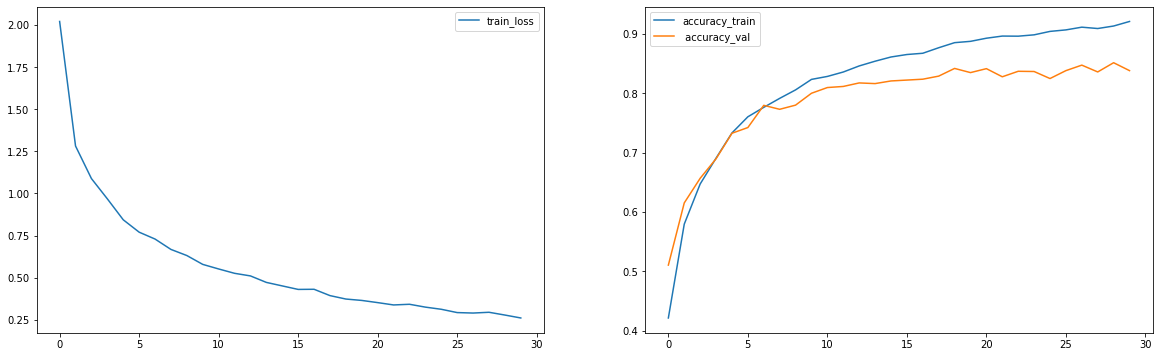

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(np.array(loss))
plt.legend(["train_loss"])
plt.subplot(1,2,2)
plt.plot(np.array(accuracy_train))
plt.plot(np.array(accuracy_val))
plt.legend(["accuracy_train"," accuracy_val"])

with lr_shedular (i could't try it because of the gpu limitation)

In [ ]:
mdl_2=SAT_CNN()
learning_rate=1e-4 # with the amount of parameters we should lower the learning rate

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(mdl_2.parameters(), lr=learning_rate)
# we add a shedullar
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.1)


loss_lr, accuracy_val_lr, accuracy_train_lr=train(mdl_2, loss_fn, optimizer, epochs=EPOCHS, lr_scheduler=lr_scheduler)

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(np.array(loss_lr))
plt.legend(["train_loss"])
plt.subplot(1,2,2)
plt.plot(np.array(accuracy_train_lr))
plt.plot(np.array(accuracy_val_lr))
plt.legend(["accuracy_train"," accuracy_val"])

## Second test : Transfer Learning 

We initialized our model's feature extraction layers with those of the VGG model, which had been pre-trained on the Imagenet dataset (1k labels). This technique can significantly speed up the optimization of the model. Moreover, the pre-trained part can help the model capture features that it might not otherwise have been able to learn through standard training.

In [ ]:
class Trans_Vgg(nn.Module):
  def __init__(self, transformers=None) -> None:
      super().__init__()
      vgg=models.vgg16(weights='IMAGENET1K_V1')

      self.features=nn.Sequential(*vgg.features.children()).to(device)

      self.classifier=nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 10),
        ).to(device)
        
      if transformers:
          self.trans=transformers

    
  def forward(self, x):

        if len(x.shape)==3:
            x=torch.unsqueeze(x, 0) # pour le cas d'une seul image 

        features=self.features(x)
        flat=torch.flatten(features,1)
        results=self.classifier(flat)
        return results

In [ ]:
mdl_2=Trans_Vgg()
learning_rate=1e-4  # with the amount of parameters we should lower the learning rate

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(mdl_2.parameters(), lr=learning_rate)
# we add a shedullar
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.1)

In [ ]:
loss_vgg, accuracy_val_vgg, accuracy_train_vgg=train(mdl_2, loss_fn, optimizer, epochs=EPOCHS)
torch.save(mdl.state_dict(), "/content/gdrive/MyDrive/space/model_vgg.pth")

epoch : 0, loss: 0.803491671784566, accuracy: 0.9162962962962963
epoch : 1, loss: 0.3217924160961359, accuracy: 0.937037037037037
epoch : 2, loss: 0.22768200964173688, accuracy: 0.9396296296296296
epoch : 3, loss: 0.17956150068244317, accuracy: 0.945925925925926
epoch : 4, loss: 0.15084987573605307, accuracy: 0.9688888888888889
epoch : 5, loss: 0.12849951370759763, accuracy: 0.965925925925926
epoch : 6, loss: 0.1304977775886159, accuracy: 0.9492592592592592
epoch : 7, loss: 0.09448651210877654, accuracy: 0.9629629629629629
epoch : 8, loss: 0.09186920074665245, accuracy: 0.9655555555555555
epoch : 9, loss: 0.08697630794627245, accuracy: 0.9677777777777777
epoch : 10, loss: 0.07179579068936742, accuracy: 0.967037037037037
epoch : 11, loss: 0.08839643979844417, accuracy: 0.9629629629629629
epoch : 12, loss: 0.05195867996615066, accuracy: 0.9725925925925926
epoch : 13, loss: 0.059360184583589035, accuracy: 0.9685185185185186
epoch : 14, loss: 0.06951568462362924, accuracy: 0.96592592592592

NameError: ignored

In [ ]:
torch.save(mdl_2.state_dict(), "/content/gdrive/MyDrive/space/model_vgg.pth")

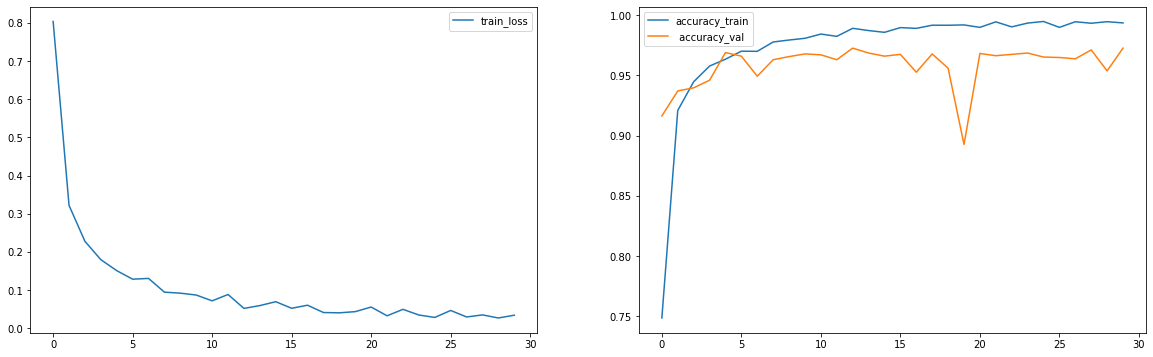

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(np.array(loss_vgg))
plt.legend(["train_loss"])
plt.subplot(1,2,2)
plt.plot(np.array(accuracy_train_vgg))
plt.plot(np.array(accuracy_val_vgg))
plt.legend(["accuracy_train"," accuracy_val"])

Based on the results on the validation dataset and the reduced overfitting, I believe that the model utilizing the pre-trained VGG architecture is superior. It converges faster to the solution and demonstrates less overfitting compared to the previous model.

Constraints of the current solution:

* The model has a slow training process, especially without transfer learning.
* Overfitting is observed, where the accuracy of the train set is higher than that of the validation set.
* The model struggles to differentiate similar images, such as pastures and a green lake.

Potential improvements to the solution:

* Implement Optuna, a library that can test different parameters such as the learning rate, number of layers, etc., to find the optimal solution.
* Explore other pre-trained models for transfer learning, such as ResNet, that are trained on similar topics and may improve the model's performance.
* Increase the available GPU resources to speed up the model's training and testing process.
* Apply data augmentation techniques such as horizontal flip, grayscale, etc. to increase the number of samples and gather more information about the labels with lower examples.